In [118]:
%pip install --quiet cplex

Note: you may need to restart the kernel to use updated packages.


In [119]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer, ADMMOptimizer, CobylaOptimizer, ADMMParameters
from qiskit_optimization import QuadraticProgram
import numpy as np
import matplotlib.pyplot as plt

In [120]:
num_bins = 20                                   # Number of time bins
e = np.array([50, 10, 50, 50, 10])              # Energy requests in kWh
num_evs = len(e)                                # Number of charging spaces or outlets
V = 240                                         # Voltage in volts
dt = 0.5                                        # Time step duration in hours
max_power = 50                                  # Maximum power in kW
arr_times = np.array([0, 3, 4, 6, 7])           # Arrival time bins
dep_times = np.array([13, 10, 19, 20, 17])      # Departure time bins

In [121]:
# Initialize the model
mdl = Model(name='EV Charging Schedule')

# Decision variable: charging current for each EV at each time step
r = mdl.integer_var_matrix(num_evs, num_bins, lb=0, ub=64, name='r')

# Compute delivered energy for each EV in kWh
delivered_energy = [mdl.sum(r[i, t] for t in range(num_bins)) * V * dt / 1000 for i in range(num_evs)]

# Compute energy deviation for each EV
energy_deviation = [delivered_energy[i] - e[i] for i in range(num_evs)]

# Fast charging incentive: penalize later charging times
time_penalty = np.zeros((num_evs, num_bins))
for i in range(num_evs):
    time_penalty[i, arr_times[i]:dep_times[i]] = np.arange(arr_times[i], dep_times[i])

# First Objective function
fast_charging = mdl.sum(r[i, t] * time_penalty[i, t] for i in range(num_evs) for t in range(num_bins))

# Second objective function
objective = mdl.sum(energy_deviation[i] for i in range(num_evs)) + 0.01 * fast_charging
mdl.minimize(objective)

# Constraints
mdl.add_constraints(mdl.sum(r[i, t] for i in range(num_evs)) * V / 1000 <= max_power for t in range(num_bins))
mdl.add_constraints(delivered_energy[i] <= e[i] for i in range(num_evs))

# Time constraints for each EV
for i in range(num_evs):
    if arr_times[i] > 0:
        mdl.add_constraints(r[i, t] == 0 for t in range(arr_times[i]))
    if dep_times[i] < num_bins:
        mdl.add_constraints(r[i, t] == 0 for t in range(dep_times[i], num_bins))
        
mdl.prettyprint()


// This file has been generated by DOcplex
// model name is: EV Charging Schedule
// var contrainer section
dvar int r[5][20];

minimize
 0.120000 r_0_0 + 0.130000 r_0_1 + 0.140000 r_0_2 + 0.150000 r_0_3
 + 0.160000 r_0_4 + 0.170000 r_0_5 + 0.180000 r_0_6 + 0.190000 r_0_7
 + 0.200000 r_0_8 + 0.210000 r_0_9 + 0.220000 r_0_10 + 0.230000 r_0_11
 + 0.240000 r_0_12 + 0.120000 r_0_13 + 0.120000 r_0_14 + 0.120000 r_0_15
 + 0.120000 r_0_16 + 0.120000 r_0_17 + 0.120000 r_0_18 + 0.120000 r_0_19
 + 0.120000 r_1_0 + 0.120000 r_1_1 + 0.120000 r_1_2 + 0.150000 r_1_3
 + 0.160000 r_1_4 + 0.170000 r_1_5 + 0.180000 r_1_6 + 0.190000 r_1_7
 + 0.200000 r_1_8 + 0.210000 r_1_9 + 0.120000 r_1_10 + 0.120000 r_1_11
 + 0.120000 r_1_12 + 0.120000 r_1_13 + 0.120000 r_1_14 + 0.120000 r_1_15
 + 0.120000 r_1_16 + 0.120000 r_1_17 + 0.120000 r_1_18 + 0.120000 r_1_19
 + 0.120000 r_2_0 + 0.120000 r_2_1 + 0.120000 r_2_2 + 0.120000 r_2_3
 + 0.160000 r_2_4 + 0.170000 r_2_5 + 0.180000 r_2_6 + 0.190000 r_2_7
 + 0.200000 r_2_8

In [122]:
qp = from_docplex_mp(mdl)
print(qp.prettyprint())

Problem name: EV Charging Schedule

Minimize
  0.12*r_0_0 + 0.13*r_0_1 + 0.22*r_0_10 + 0.22999999999999998*r_0_11
  + 0.24*r_0_12 + 0.12*r_0_13 + 0.12*r_0_14 + 0.12*r_0_15 + 0.12*r_0_16
  + 0.12*r_0_17 + 0.12*r_0_18 + 0.12*r_0_19 + 0.13999999999999999*r_0_2
  + 0.15*r_0_3 + 0.16*r_0_4 + 0.16999999999999998*r_0_5 + 0.18*r_0_6
  + 0.19*r_0_7 + 0.2*r_0_8 + 0.21*r_0_9 + 0.12*r_1_0 + 0.12*r_1_1 + 0.12*r_1_10
  + 0.12*r_1_11 + 0.12*r_1_12 + 0.12*r_1_13 + 0.12*r_1_14 + 0.12*r_1_15
  + 0.12*r_1_16 + 0.12*r_1_17 + 0.12*r_1_18 + 0.12*r_1_19 + 0.12*r_1_2
  + 0.15*r_1_3 + 0.16*r_1_4 + 0.16999999999999998*r_1_5 + 0.18*r_1_6
  + 0.19*r_1_7 + 0.2*r_1_8 + 0.21*r_1_9 + 0.12*r_2_0 + 0.12*r_2_1 + 0.22*r_2_10
  + 0.22999999999999998*r_2_11 + 0.24*r_2_12 + 0.25*r_2_13 + 0.26*r_2_14
  + 0.27*r_2_15 + 0.28*r_2_16 + 0.29000000000000004*r_2_17 + 0.3*r_2_18
  + 0.12*r_2_19 + 0.12*r_2_2 + 0.12*r_2_3 + 0.16*r_2_4
  + 0.16999999999999998*r_2_5 + 0.18*r_2_6 + 0.19*r_2_7 + 0.2*r_2_8 + 0.21*r_2_9
  + 0.12*r_3_0 + 0.1

In [123]:
# define QUBO optimizer
# qubo_optimizer = exact
qubo_optimizer = CplexOptimizer()  

# define classical optimizer
# convex_optimizer = cobyla
convex_optimizer = CobylaOptimizer()

admm_params = ADMMParameters(
    rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-6
)

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)

In [124]:
# result = admm.solve(qp)

In [125]:
# Solve the model
solution = mdl.solve()

optimized_schedule = np.array([[r[i, t].solution_value for t in range(num_bins)] for i in range(num_evs)])

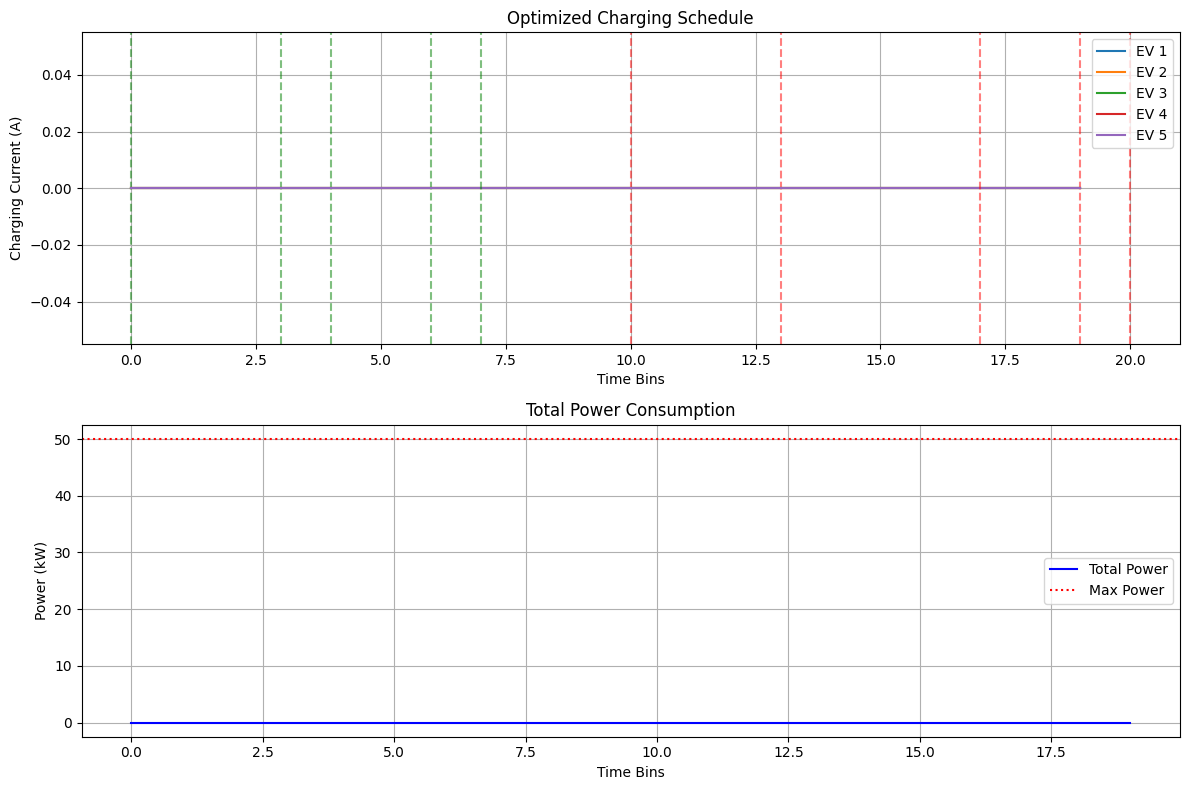

In [126]:
 # Plotting
plt.figure(figsize=(12, 8))

# Charging schedule plot
plt.subplot(2, 1, 1)
for i in range(num_evs):
    plt.step(range(num_bins), optimized_schedule[i], label=f'EV {i+1}', where='post')
    plt.axvline(x=arr_times[i], color='g', linestyle='--', alpha=0.5)
    plt.axvline(x=dep_times[i], color='r', linestyle='--', alpha=0.5)

plt.xlabel('Time Bins')
plt.ylabel('Charging Current (A)')
plt.title('Optimized Charging Schedule')
plt.legend(loc='upper right')
plt.grid(True)

# Total power consumption plot
plt.subplot(2, 1, 2)
total_power = np.sum(optimized_schedule, axis=0) * V / 1000
plt.plot(range(num_bins), total_power, 'b-', label='Total Power')
plt.axhline(y=max_power, color='r', linestyle=':', label='Max Power')
plt.xlabel('Time Bins')
plt.ylabel('Power (kW)')
plt.title('Total Power Consumption')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [127]:
if optimized_schedule is not None:
    print("Optimized Charging Schedule (Amperes):")
    print(optimized_schedule)

    # Calculate delivered energy
    delivered_energy = np.sum(optimized_schedule, axis=1) * V * dt / 1000
    print("\nDelivered Energy (kWh):")
    print(delivered_energy)

    print("\nRequested Energy (kWh):")
    print(e)

    print(f"\nTotal Energy Delivered: {np.sum(delivered_energy):.2f} kWh")
    print(f"Maximum Power: {max_power} kW")

else:
    print("Optimization failed to find a solution.")

Optimized Charging Schedule (Amperes):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Delivered Energy (kWh):
[0. 0. 0. 0. 0.]

Requested Energy (kWh):
[50 10 50 50 10]

Total Energy Delivered: 0.00 kWh
Maximum Power: 50 kW


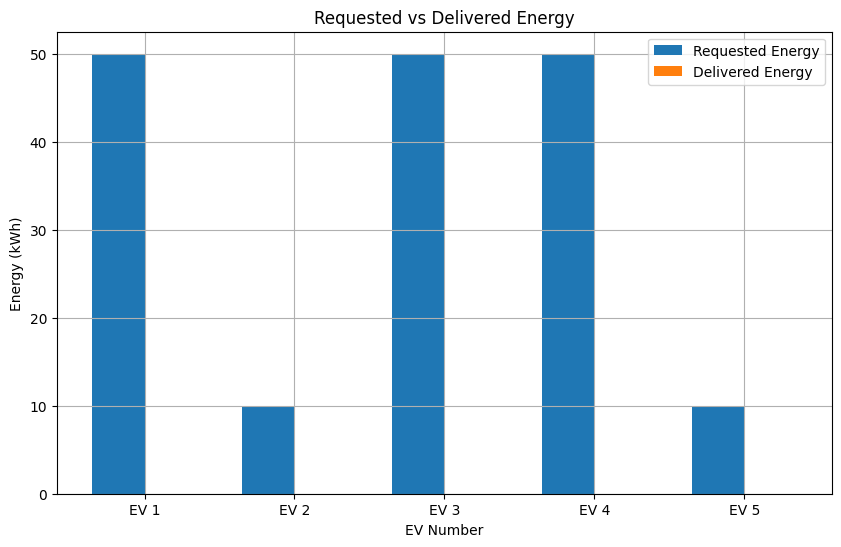

In [128]:
# Energy delivery plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(num_evs)
plt.bar(index, e, bar_width, label='Requested Energy')
plt.bar(index + bar_width, delivered_energy, bar_width, label='Delivered Energy')
plt.xlabel('EV Number')
plt.ylabel('Energy (kWh)')
plt.title('Requested vs Delivered Energy')
plt.xticks(index + bar_width/2, [f'EV {i+1}' for i in range(num_evs)])
plt.legend()
plt.grid(True)
plt.show()